In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from training.model_training import NN, get_loaders, get_accuracy
from interface.interfacer import PseudoHardwareNN
from interface.IOTransfer import quantize

from hardware.crossbars import SimpleCrossbar, SimpleCrossbar2, DifferentialCrossbar

In [2]:
def compare_models(models=[], names=None, max_samples=10):

    if names is None:
        names = [f"Model {i}" for i in range(len(models))]

    test_data = get_loaders(batch_size=1, train=False, dataset_path="datasets/")
    confusion_matrices = [np.zeros((10, 10)) for _ in models]
    total_samples = 0
    models_corrects = [0 for _ in models]
    device = "cpu"

    with torch.no_grad():
        
        for data in test_data:

            if max_samples is not None and total_samples >= max_samples:
                break

            images, labels = data
            images, labels = images.to(device), labels.to(device)
            total_samples += labels.size(0)

            for i, model in enumerate(models):
                print(f"Testing {names[i]}, {total_samples}/{max_samples} Tested", end="\r")

                outputs = model(images)
                _, predicted = torch.max(outputs, 1)

                models_corrects[i] += (predicted == labels).sum().item()

                confusion_matrices[i][labels, predicted] += 1




    # print accuracy
    for i, model in enumerate(models):
        print(f"{names[i]}: {models_corrects[i] / total_samples}")

    # Plot confusion matrices for each model
    fig, axs = plt.subplots(1, len(models), figsize=(5*len(models), 5))

    # print(len(axs))
    for i, model in enumerate(models):
        if len(models) == 1:
            ax = axs
        else:
            ax = axs[i]
        ax.imshow(confusion_matrices[i], cmap='hot', interpolation='nearest')
        ax.set_title(f"{names[i]}; Accuracy: {models_corrects[i] / total_samples}")
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        # for j in range(10):
        #     for k in range(10):
        #         ax.text(j, k, int(confusion_matrices[i][j, k]), ha="center", va="center", color="black")

    plt.show()

In [3]:
model_path = "training/model.pth"
l1_model_path = "training/model_l1reg.pth"
device = "cpu" # TODO need to fix for cuda and mps (atleast the software model)


ann = NN()                                        
ann_reg = NN()
hwnn = PseudoHardwareNN(hardware_multiplier=SimpleCrossbar2, 
                                        input_quantization=(True, 0.01),
                                        weight_quantization=(True, 0.05, [-1,1]),
                                        output_quantization=(True, 0.01),
                                        weight_variance=(True, 0.05),
                                        inline_resistances=(True, (1e-4, 1e-4)),
                                        verbose=False)

hwnn_l1reg = PseudoHardwareNN(hardware_multiplier=SimpleCrossbar2, 
                                        input_quantization=(True, 0.01),
                                        weight_quantization=(True, 0.05, [-1,1]),
                                        output_quantization=(True, 0.01),
                                        weight_variance=(True, 0.05),
                                        inline_resistances=(True, (1e-4, 1e-4)),
                                        verbose=False)


# hwnn2 = PseudoHardwareNN(hardware_multiplier=SimpleCrossbar2, 
#                                         input_quantization=(True, 0.01),
#                                         weight_quantization=(True, 0.05, [-1,1]),
#                                         output_quantization=(True, 0.01),
#                                         inline_resistances=(True, (1e-4, 1e-4)))
# hwnn3 = PseudoHardwareNN(hardware_multiplier=DifferentialCrossbar,
#                                         input_quantization=(True, 0.01),
#                                         weight_quantization=(True, 0.05, [-1,1]),
#                                         output_quantization=(True, 0.01),
#                                         inline_resistances=(True, (1e-4, 1e-4)))


models = [ann, hwnn] #, hwnn3]

for model in models:
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

ann_reg.load_state_dict(torch.load(l1_model_path))
ann_reg.to(device)
ann_reg.eval()

models.append(ann_reg)

hwnn_l1reg.load_state_dict(torch.load(l1_model_path))
hwnn_l1reg.to(device)
hwnn_l1reg.eval()

models.append(hwnn_l1reg)

# dataset
test_data = get_loaders(batch_size=1, train=False, dataset_path="datasets/")
max_samples = 50

compare_models(models, names=['ann', 'hnn', 'ann_reg', 'hnn_reg'],max_samples=max_samples)


2024-05-20 21:23:50,540 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.ERROR - Note: can't find the initialization file spinit.
2024-05-20 21:23:50,542 - PySpice.Spice.NgSpice.Shared.NgSpiceShared - Shared.WARNING - Unsupported Ngspice version 42


In [ ]:
# plt.bar(["Software", "Ideal Hardware", "QSI"], [software_accuracy,hardware_accuracy, hardware_quantized_accuracy])
# plt.hlines(software_accuracy, -0.5, 2.5, colors="r", linestyles="dashed", label="Software Baseline")
# plt.ylabel("Accuracy")
# plt.title("Model Accuracy")
# plt.legend()
# plt.show()

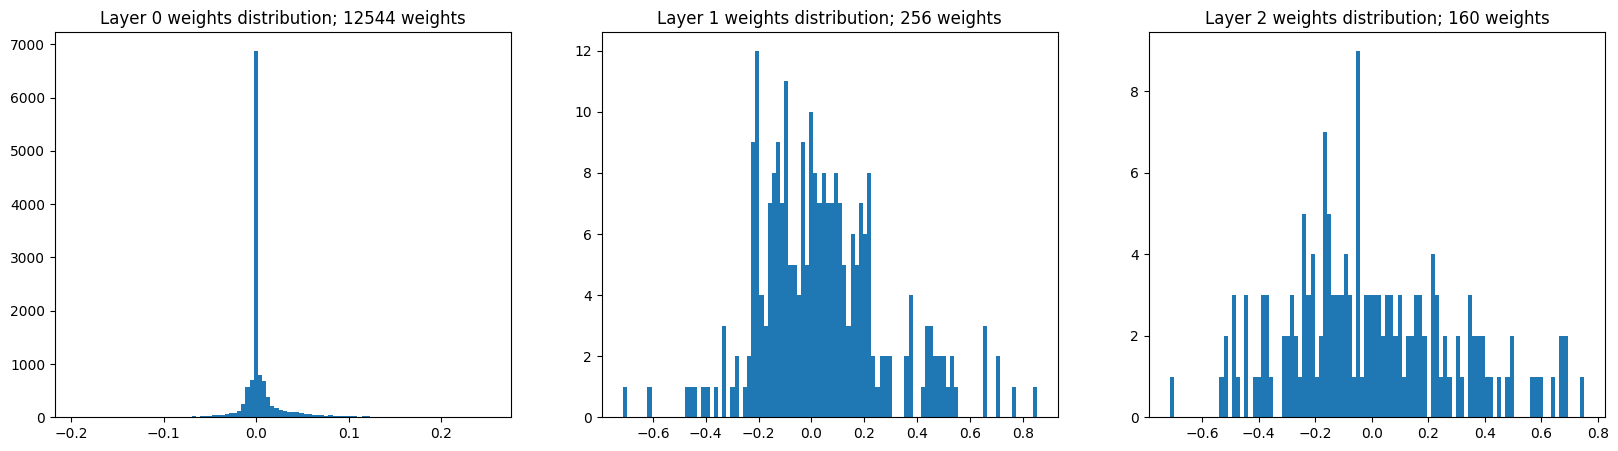

In [ ]:
# plot weight distributions

def plot_weights(model, layer_idx=None):

    if layer_idx is not None:
        for i, layer in enumerate(model.children()):
            if i == layer_idx:
                mylayer = layer
                break

        weights = mylayer.weight.detach().numpy().flatten()
        plt.hist(weights, bins=100)
        plt.title(f"Layer {layer_idx} weights distribution")
        plt.show()

    # side by side comparison
    else:
        total_layers = len(list(model.children()))
        fig, axs = plt.subplots(1, total_layers, figsize=(20, 5))
        

        for i, layer in enumerate(model.children()):
            weights = layer.weight.detach().numpy().flatten()
            total_weights = len(weights)

            axs[i].hist(weights, bins=100)
            axs[i].set_title(f"Layer {i} weights distribution; {total_weights} weights")


        
        plt.show()

plot_weights(ann_reg)

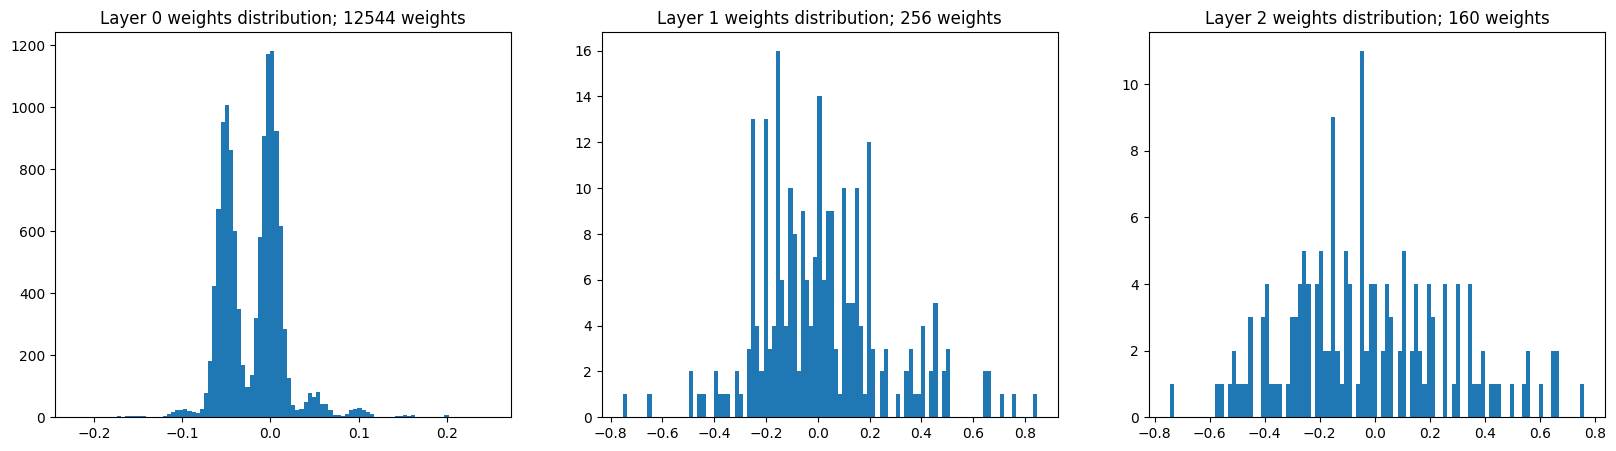

In [ ]:
def plot_weights(model, layer_idx=None):

    if layer_idx is not None:
        for i, layer in enumerate(model.children()):
            if i == layer_idx:
                mylayer = layer
                break

        weights = quantize(mylayer.weight.detach().numpy().flatten(), 0.05, [-1,1])

        
        plt.hist(weights, bins=100)
        plt.title(f"Layer {layer_idx} weights distribution")
        plt.show()

    # side by side comparison
    else:
        total_layers = len(list(model.children()))
        fig, axs = plt.subplots(1, total_layers, figsize=(20, 5))

        for i, layer in enumerate(model.children()):
            weights = quantize(layer.weight.detach().numpy().flatten(), 0.05, [-1,1]) + np.random.normal(0, 0.01, len(layer.weight.detach().numpy().flatten()))
            total_weights = len(weights)

            axs[i].hist(weights, bins=100)
            axs[i].set_title(f"Layer {i} weights distribution; {total_weights} weights")


        
        plt.show()

plot_weights(ann_reg)

In [ ]:
import torch
import numpy as np

def conv2mm(kernel, input_tensor):
    """
    Returns the flattened kernel and corresponding 2D matrix of the input tensor
    such that the convolution operation can be represented as a matrix multiplication
    """

    input_tensor = input_tensor.flatten()

    # toeplitz matrix
    kernel = kernel.flatten()
    kernel_size = len(kernel)
    input_size = len(input_tensor)
    output_size = input_size - kernel_size + 1

    toeplitz_matrix = np.zeros((output_size, input_size))

    for i in range(output_size):
        toeplitz_matrix[i, i:i+kernel_size] = kernel

    return torch.tensor(toeplitz_matrix), input_tensor

    

## check correctness of conv2mm

my_kernel = torch.tensor([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
inputImage = torch.tensor([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]])

toeplitz_matrix, input_tensor = conv2mm(my_kernel, inputImage)

print(np.dot(toeplitz_matrix, input_tensor))
# print(np.matmul(toeplitz_matrix, input_tensor))
print(torch.nn.functional.conv2d(inputImage.unsqueeze(0).unsqueeze(0), my_kernel.unsqueeze(0).unsqueeze(0)))


[15. 18. 21. 24. 27. 30. 33. 36.]
tensor([[[[18, 21],
          [30, 33]]]])
